# **Autoencoders**

In [42]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt


def plot_image(image):
    """functions to plot grayscale 28x28 image
        Args:
    """
    plt.imshow(image, cmap="binary")
    plt.axis("off")


## **PCA with a linear Autoencoder**

Build 3D dataset:

In [43]:
np.random.seed(4)


def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)
X_train[0]


array([-1.03976771, -0.76023846, -0.33288048])

Now let's build the Autoencoder, remember that if the autoencoder uses **only** **linear activations**,**it has only one Hidden Layer** and the **cost function is the (MSE)**, then it ends up performing `Principal
Component Analysis (PCA)`

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(
    learning_rate=1.5), metrics=["accuracy"])


* We organized the autoencoder into two subcomponents: the
`encoder` and the `decoder`. Both are regular Sequential models
with a single Dense layer each, and the autoencoder is a
Sequential model containing the encoder followed by the
decoder (remember that a model can be used as a layer in another
model).
* The autoencoder’s number of outputs is equal to the number of
inputs (i.e., 3).

In [45]:
history = autoencoder.fit(X_train, X_train, epochs=10)

Epoch 1/10
2/2 [==============================] - 0s 9ms/step - loss: 0.4097 - accuracy: 0.4333
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 0.1386 - accuracy: 0.6167
Epoch 3/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0593 - accuracy: 0.7167
Epoch 4/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0581 - accuracy: 0.6833
Epoch 5/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.8167
Epoch 6/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0744 - accuracy: 0.7333
Epoch 7/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0524 - accuracy: 0.8333
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 0.0183 - accuracy: 0.9167
Epoch 9/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0100 - accuracy: 0.9500
Epoch 10/10
2/2 [==============================] - 0s 6ms/step - loss: 0.0062 - accuracy: 0.9167


Mostrar la reducción de la dimensionalidad(similar como lo haria PCA)

2/2 [==============================] - 0s 2ms/step


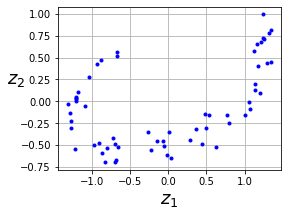

In [46]:
codings = encoder.predict(X_train)
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## **Stacked Autoencoders**

Let's use MNIST:

In [47]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).
![alt](./resources/Stacked_Autoencoders.png)

* Autoencoder model split two
submodels: the encoder and the decoder.

*  The encoder takes 28 × 28–pixel grayscale images, flattens them
so that each image is represented as a vector of size 784, then
processes these vectors through two Dense layers of diminishing
sizes (100 units then 30 units), both using the SELU activation
function (you may want to add LeCun normal initialization as
well, but the network is not very deep so it won’t make a big
difference). For each input image, the encoder outputs a vector of
size 30.

* The decoder takes codings of size 30 (output by the encoder) and
processes them through two Dense layers of increasing sizes (100
units then 784 units), and it reshapes the final vectors into 28 × 28
arrays so the decoder’s outputs have the same shape as the
encoder’s inputs.

* When compiling the stacked autoencoder, we use the `binary
cross-entropy loss` instead of the mean squared error. We are
treating the reconstruction task as a multilabel binary
classification problem: each pixel intensity represents the
probability that the pixel should be black. Framing it this way
(rather than as a regression problem) **tends to make the model
converge faster**.

* Finally, we train the model using X_train as both the inputs and
the targets (and similarly, we use X_valid as both the validation
inputs and targets).


In [48]:
tf.random.set_seed(42)
np.random.seed(42)


def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))


Epoch 1/20
1719/1719 [==============================] - 7s 3ms/step - loss: 0.3350 - rounded_accuracy: 0.8897 - val_loss: 0.3106 - val_rounded_accuracy: 0.9118
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3038 - rounded_accuracy: 0.9167 - val_loss: 0.3030 - val_rounded_accuracy: 0.9211
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2971 - rounded_accuracy: 0.9230 - val_loss: 0.2960 - val_rounded_accuracy: 0.9238
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2928 - rounded_accuracy: 0.9268 - val_loss: 0.2921 - val_rounded_accuracy: 0.9302
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2899 - rounded_accuracy: 0.9296 - val_loss: 0.2900 - val_rounded_accuracy: 0.9298
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2879 - rounded_accuracy: 0.9314 - val_loss: 0.2885 - val_rounded_accuracy: 0.9330
Epoch 7/20
1719/1719 [==================

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

1/1 [==============================] - 0s 98ms/step


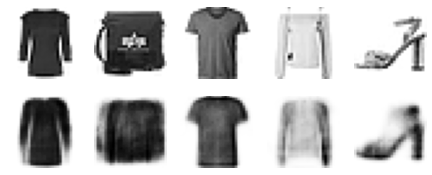

In [49]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])


show_reconstructions(stacked_ae)


Las reconstrucciones son reconocibles, pero un poco demasiado perdidas. Es posible que
necesitemos entrenar el modelo durante más tiempo, o hacer que el codificador y el
decodificador sean más profundos, o hacer que las codificaciones sean más grandes. Pero si
hacemos que la red sea demasiado poderosa, logrará hacer reconstrucciones perfectas sin
haber aprendido ningún patrón útil en los datos

## Visualizing Fashion MNIST
Para ello vamos a utilizar la estrategia
de usar un Autoencoder para reducir la dimensionalidad a un nivel razonable y
luego usar otro algoritmo de reducción de dimensionalidad para la visualización

157/157 [==============================] - 0s 2ms/step


c:\Users\Manue!_PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Manue!_PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


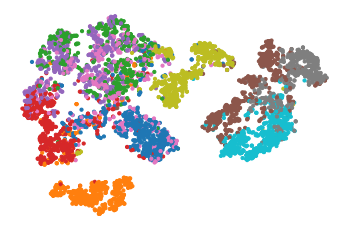

In [50]:
from sklearn.manifold import TSNE
np.random.seed(42)


X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()


Let's make this diagram a bit prettier:

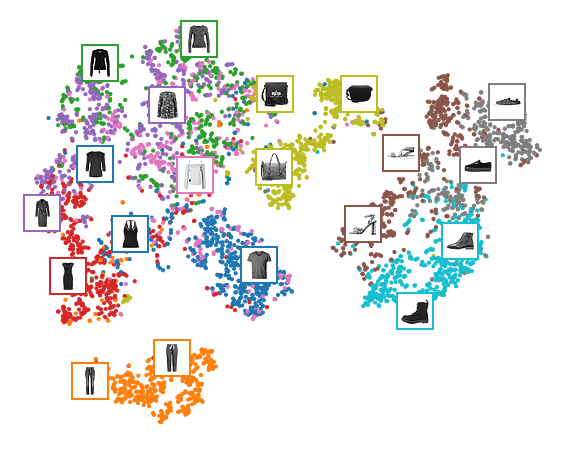

In [51]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02:  # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()


## Tying weights in stacked autoencoders


It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [52]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

* Esta capa personalizada actúa como una capa Densa regular, pero usa los pesos de otra capa Densa,
transpuestos (establecer transpose_b=True es equivalente a transponer el segundo argumento, pero
es más eficiente ya que realiza la transposición sobre la marcha dentro de la operación matmul() ). Sin
embargo, utiliza su propio vector de sesgo.
 
A continuación, podemos construir un nuevo **Stacked Autoencoders**, muy parecido al anterior, pero con las capas densas del decodificador vinculadas a las
capas densas del codificado

In [53]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3275 - rounded_accuracy: 0.8954 - val_loss: 0.3096 - val_rounded_accuracy: 0.9042
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2974 - rounded_accuracy: 0.9222 - val_loss: 0.2948 - val_rounded_accuracy: 0.9281
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2913 - rounded_accuracy: 0.9281 - val_loss: 0.2973 - val_rounded_accuracy: 0.9149
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2882 - rounded_accuracy: 0.9308 - val_loss: 0.2880 - val_rounded_accuracy: 0.9331
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2862 - rounded_accuracy: 0.9327 - val_loss: 0.2870 - val_rounded_accuracy: 0.9315
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2849 - rounded_accuracy: 0.9338 - val_loss: 0.2862 - val_rounded_accuracy: 0.9349
Epoch 7/10
1719/1719 [==================

This model achieves a very slightly lower reconstruction error than the
previous model, with almost half the number of parameters.

1/1 [==============================] - 0s 90ms/step


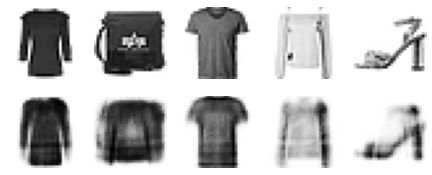

In [54]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

Durante la primera fase de entrenamiento, el primer Autoencoders aprende a reconstruir las
entradas. Luego codificamos todo el conjunto de entrenamiento usando este primer
Autoencoders, y esto nos da un nuevo conjunto de entrenamiento (comprimido). Luego
entrenamos un segundo Autoencoders en este nuevo conjunto de datos. Esta es la segunda fase de 
capacitacion . Finalmente, construimos un sándwich grande usando todos estos codificadores
automáticos




In [55]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.3449 - rounded_accuracy: 0.8872 - val_loss: 0.3121 - val_rounded_accuracy: 0.9149
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3040 - rounded_accuracy: 0.9201 - val_loss: 0.3011 - val_rounded_accuracy: 0.9238
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2957 - rounded_accuracy: 0.9276 - val_loss: 0.2944 - val_rounded_accuracy: 0.9302
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2901 - rounded_accuracy: 0.9329 - val_loss: 0.2898 - val_rounded_accuracy: 0.9350
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2863 - rounded_accuracy: 0.9366 - val_loss: 0.2867 - val_rounded_accuracy: 0.9381
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2836 - rounded_accuracy: 0.9392 - val_loss: 0.2844 - val_rounded_accuracy: 0.9398
Epoch 7/10
1719/1719 [==================

In [57]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 78ms/step


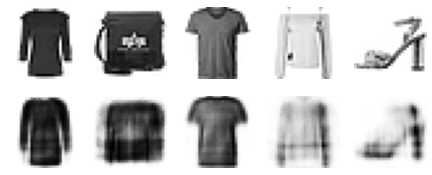

In [58]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [59]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2854 - rounded_accuracy: 0.9357 - val_loss: 0.2871 - val_rounded_accuracy: 0.9357
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2851 - rounded_accuracy: 0.9360 - val_loss: 0.2869 - val_rounded_accuracy: 0.9358
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9362 - val_loss: 0.2867 - val_rounded_accuracy: 0.9361
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2848 - rounded_accuracy: 0.9363 - val_loss: 0.2866 - val_rounded_accuracy: 0.9362
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2847 - rounded_accuracy: 0.9364 - val_loss: 0.2865 - val_rounded_accuracy: 0.9362
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2846 - rounded_accuracy: 0.9365 - val_loss: 0.2864 - val_rounded_accuracy: 0.9362
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 94ms/step


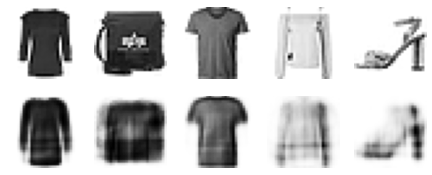

In [60]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 41s 22ms/step - loss: 0.3001 - rounded_accuracy: 0.9201 - val_loss: 0.2805 - val_rounded_accuracy: 0.9405
Epoch 2/5
1719/1719 [==============================] - 39s 23ms/step - loss: 0.2755 - rounded_accuracy: 0.9417 - val_loss: 0.2726 - val_rounded_accuracy: 0.9462
Epoch 3/5
1719/1719 [==============================] - 40s 23ms/step - loss: 0.2710 - rounded_accuracy: 0.9463 - val_loss: 0.2703 - val_rounded_accuracy: 0.9493
Epoch 4/5
1719/1719 [==============================] - 39s 23ms/step - loss: 0.2684 - rounded_accuracy: 0.9490 - val_loss: 0.2676 - val_rounded_accuracy: 0.9518
Epoch 5/5
1719/1719 [==============================] - 42s 24ms/step - loss: 0.2666 - rounded_accuracy: 0.9512 - val_loss: 0.2662 - val_rounded_accuracy: 0.9535


In [62]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 198ms/step


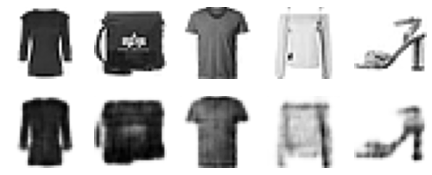

In [63]:
show_reconstructions(conv_ae)
plt.show()

___
## Stacked denoising Autoencoder

Using Gaussian noise:

In [64]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.3),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3932 - rounded_accuracy: 0.8396 - val_loss: 0.3425 - val_rounded_accuracy: 0.8870
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3290 - rounded_accuracy: 0.8962 - val_loss: 0.3219 - val_rounded_accuracy: 0.9038
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3186 - rounded_accuracy: 0.9047 - val_loss: 0.3160 - val_rounded_accuracy: 0.9077
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3140 - rounded_accuracy: 0.9086 - val_loss: 0.3122 - val_rounded_accuracy: 0.9119
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3110 - rounded_accuracy: 0.9111 - val_loss: 0.3096 - val_rounded_accuracy: 0.9141
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3086 - rounded_accuracy: 0.9131 - val_loss: 0.3075 - val_rounded_accuracy: 0.9158
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 80ms/step


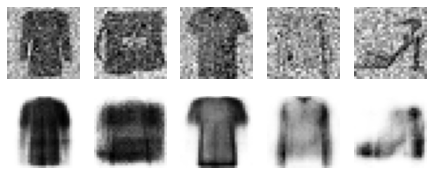

In [65]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [66]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.4),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3895 - rounded_accuracy: 0.8442 - val_loss: 0.3416 - val_rounded_accuracy: 0.8866
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3327 - rounded_accuracy: 0.8917 - val_loss: 0.3221 - val_rounded_accuracy: 0.9024
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3224 - rounded_accuracy: 0.8999 - val_loss: 0.3168 - val_rounded_accuracy: 0.9062
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3184 - rounded_accuracy: 0.9029 - val_loss: 0.3148 - val_rounded_accuracy: 0.9102
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3157 - rounded_accuracy: 0.9051 - val_loss: 0.3115 - val_rounded_accuracy: 0.9111
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3136 - rounded_accuracy: 0.9067 - val_loss: 0.3100 - val_rounded_accuracy: 0.9110
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 115ms/step


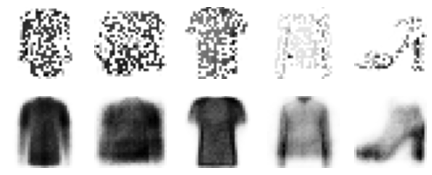

In [67]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

Observe cómo el codificador automático adivina detalles que en realidad no están en la
entrada, como la parte superior de la camisa blanca (fila inferior, cuarta imagen).
___


## Sparse Autoencoder

Let's build a simple stacked autoencoder, so we can compare it to the sparse autoencoders we will build. This time we will use the sigmoid activation function for the coding layer, to ensure that the coding values range from 0 to 1:

In [68]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4267 - rounded_accuracy: 0.8006 - val_loss: 0.3756 - val_rounded_accuracy: 0.8514
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3599 - rounded_accuracy: 0.8690 - val_loss: 0.3510 - val_rounded_accuracy: 0.8801
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3420 - rounded_accuracy: 0.8849 - val_loss: 0.3393 - val_rounded_accuracy: 0.8863
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3306 - rounded_accuracy: 0.8946 - val_loss: 0.3270 - val_rounded_accuracy: 0.9003
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3219 - rounded_accuracy: 0.9012 - val_loss: 0.3213 - val_rounded_accuracy: 0.9022
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3178 - rounded_accuracy: 0.9040 - val_loss: 0.3177 - val_rounded_accuracy: 0.9051
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 103ms/step


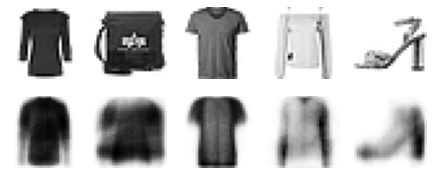

In [69]:
show_reconstructions(simple_ae)

Let's create a couple functions to print nice activation histograms:

In [70]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)
    
    
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer. The histogram on the left shows the distribution of all the activations. You can see that values close to 0 or 1 are more frequent overall, which is consistent with the saturating nature of the sigmoid function. The histogram on the right shows the distribution of mean neuron activations: you can see that most neurons have a mean activation close to 0.5. Both histograms tell us that each neuron tends to either fire close to 0 or 1, with about 50% probability each. However, some neurons fire almost all the time (right side of the right histogram).

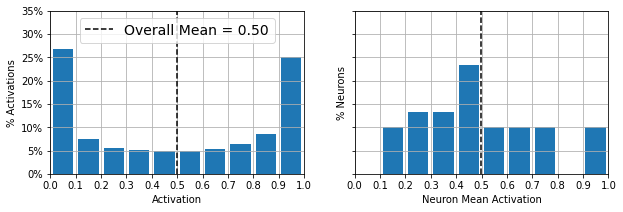

In [71]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

### Now let's add $\ell_1$ regularization to the coding layer:

Esta capa de `ActivityRegularization` solo devuelve sus entradas, pero como efecto
secundario agrega una pérdida de entrenamiento igual a la suma de los valores
absolutos de sus entradas (esta capa solo tiene efecto durante el entrenamiento). De
manera equivalente, podría eliminar la capa
ActivityRegularization y establecer activity_regularizer=keras.regularizers.l1(1e3) en la
capa anterior. 
 
Esta penalización alentará a la red neuronal a producir codificaciones
cercanas a 0, pero dado que también será penalizada si no reconstruye las
entradas correctamente, tendrá que generar al menos algunos valores distintos de
cero. El uso de la norma ℓ1 en lugar de la norma ℓ2 impulsará a la red neuronal a
preservar las codificaciones más importantes mientras elimina las que no son necesarias
para la imagen de entrada (en lugar de simplemente reducir todas las codificaciones)

In [72]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4309 - rounded_accuracy: 0.8170 - val_loss: 0.3835 - val_rounded_accuracy: 0.8511
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3698 - rounded_accuracy: 0.8684 - val_loss: 0.3655 - val_rounded_accuracy: 0.8702
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3563 - rounded_accuracy: 0.8787 - val_loss: 0.3512 - val_rounded_accuracy: 0.8829
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3443 - rounded_accuracy: 0.8864 - val_loss: 0.3423 - val_rounded_accuracy: 0.8894
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3376 - rounded_accuracy: 0.8913 - val_loss: 0.3368 - val_rounded_accuracy: 0.8945
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3318 - rounded_accuracy: 0.8967 - val_loss: 0.3314 - val_rounded_accuracy: 0.9003
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 100ms/step


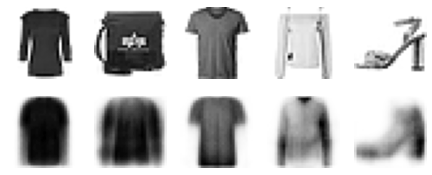

In [73]:
show_reconstructions(sparse_l1_ae)

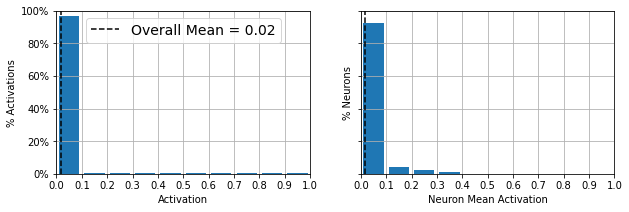

In [74]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

### Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

(0.0, 1.0, 0.0, 0.95)

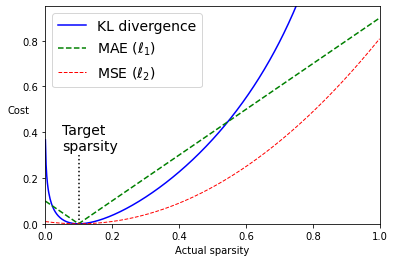

In [75]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [76]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 4ms/step - loss: 0.4166 - rounded_accuracy: 0.8099 - val_loss: 0.3712 - val_rounded_accuracy: 0.8583
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3526 - rounded_accuracy: 0.8778 - val_loss: 0.3427 - val_rounded_accuracy: 0.8872
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3321 - rounded_accuracy: 0.8943 - val_loss: 0.3268 - val_rounded_accuracy: 0.9002
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3208 - rounded_accuracy: 0.9036 - val_loss: 0.3200 - val_rounded_accuracy: 0.9056
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3157 - rounded_accuracy: 0.9076 - val_loss: 0.3160 - val_rounded_accuracy: 0.9090
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3125 - rounded_accuracy: 0.9102 - val_loss: 0.3131 - val_rounded_accuracy: 0.9108
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 129ms/step


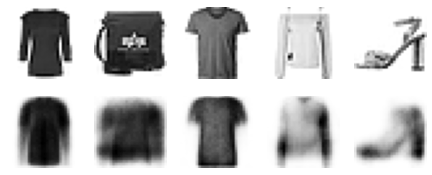

In [78]:
show_reconstructions(sparse_kl_ae)

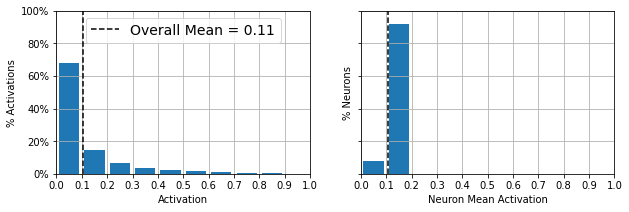

In [79]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

## Variational Autoencoder


`Sampling` toma dos entradas:**media (μ)** y **log_var (γ)**. Utiliza la función
`K.random_normal()` para muestrear un vector aleatorio (de la misma shape que γ) con distribución
Normal, con media 0 y desviación estándar 1.
 
Luego lo multiplica por exp(γ / 2) (que es igual a **σ**, como puedes comprobar), y finalmente le
suma **μ** y devuelve el resultado. Esto muestra un vector de codificación de la distribución Normal
con media μ y desviación estándar σ.A  continuación, podemos crear el codificador usando la API funcional porque el modelo no
es completamente secuencial:

In [80]:
class Sampling(keras.layers.Layer):
    """capa personalizada para muestrear las codificaciones, dadas μ y γ:"""
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [89]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10
# ____________________Encoder
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)

codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

# 3 salidas, por inspeccionar los valoresde codings_mean y codings_log_var
# La única salida que usaremos es la última (codings).
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# __________________Decoder
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

# _____________ Build the Varational Autoencoders
# solo nos interesa el resultado del Sampling(i.e codings)
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# _____________ Add the Latent_Loss

# compute the latent loss for each instance in the batch (we sum over the last axis).
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis=-1)
# compute the mean loss over all the instances in the batch, and we divide the result by 784 to
# ensure it has the appropriate scale compared to the reconstruction loss.
variational_ae.add_loss(K.mean(latent_loss) / 784.)

# Se supone que reconstruction_loss del varational autoencoder es la suma de los errores de\
# reconstrucción de píxeles, pero cuando Keras calcula la pérdida de ""binary_crossentropy, 
# calcula la media de los 784 píxeles, en lugar de la suma. Entonces, la pérdida de reconstrucción es 784 veces menor de lo que necesitamos

variational_ae.compile(loss="binary_crossentropy", optimizer="adam", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))


Epoch 1/25
430/430 [==============================] - 6s 9ms/step - loss: 0.3672 - rounded_accuracy: 0.8799 - val_loss: 0.3381 - val_rounded_accuracy: 0.9065
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3308 - rounded_accuracy: 0.9091 - val_loss: 0.3282 - val_rounded_accuracy: 0.9113
Epoch 3/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3238 - rounded_accuracy: 0.9137 - val_loss: 0.3234 - val_rounded_accuracy: 0.9157
Epoch 4/25
430/430 [==============================] - 3s 8ms/step - loss: 0.3200 - rounded_accuracy: 0.9162 - val_loss: 0.3210 - val_rounded_accuracy: 0.9174
Epoch 5/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3179 - rounded_accuracy: 0.9177 - val_loss: 0.3198 - val_rounded_accuracy: 0.9158
Epoch 6/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3165 - rounded_accuracy: 0.9186 - val_loss: 0.3178 - val_rounded_accuracy: 0.9181
Epoch 7/25
430/430 [==============================]

1/1 [==============================] - 0s 189ms/step


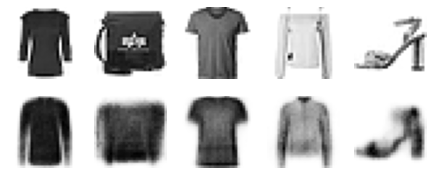

In [82]:
show_reconstructions(variational_ae)
plt.show()

### Generate Fashion Images
Todo lo que
tenemos que hacer es tomar muestras de codificaciones aleatorias de una distribución gaussiana y
decodificarlas:

In [83]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

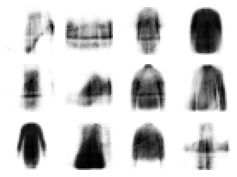

In [84]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

`Semantic interpolation`: en lugar de interpolar dos imágenes a nivel de píxel (lo que parecería que las
dos imágenes estuvieran superpuestas), podemos interpolar a nivel de codificación.
Primero ejecutamos ambas imágenes a través del codificador, luego interpolamos
las dos codificaciones que obtenemos y finalmente decodificamos las codificaciones
interpoladas para obtener la imagen final. Se verá como una imagen normal de Fashion
MNIST, pero será un intermedio entre las imágenes originales.

 En el siguiente ejemplo
de código, tomamos las 12 codificaciones que acabamos de generar, las organizamos
en una cuadrícula de 3 × 4 y usamos la función tf.image.resize() de TensorFlow para
cambiar el tamaño de esta cuadrícula a 5 × 7. De forma predeterminada, el la función resize()realice una interpolación bilineal, de modo que cada dos filas y columnas contengan
codificaciones interpoladas. Luego usamos el decodificador para producir todas las imágenes:




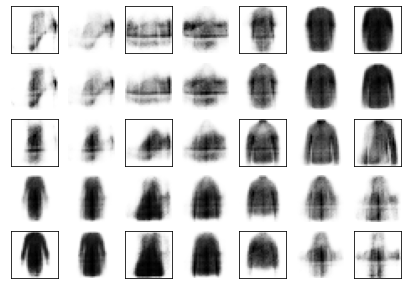

In [85]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")